This post part of my series [TensorFlow From The Ground Up]({category}tensorflow-from-the-ground-up).

In my previous post [Learning to Add]({filename}Learning to Add.md), I showed how a Neural Network architecture can learn a simple linear function of two variables.  

In this post, we'll explore how to take our functions from linear to nonlinear.  Additionally, we'll work on going some **regressions** and see what happens when we try to learn nonlinear functions. 

## Composing linear functions

One of the key points of linear functions is that the composition of two linear functions is also a linear function.  The math behind this is fairly straightforward: 

$$\begin{array}{rl}
f(x) & = wx+b \\
f(f(x)) & = w_2(w_1x+b_1)+b_2 \\
& = (w_2w_1)x+(w_2b_1+b_2) \\
\end{array}$$

As you can see, the composed form of $f(f(x))$ is also a linear function, just with $w = w_2w_1$ and $b = w_2b_1+b_2$

Or, to think of this differently:  Without any **nonlinear elements** in our neural network architecture, there's no reason to have any more than one node in the middle layer, because even a giant collection of linear functions still result in a single linear transformation.  

An exception to this is functions of multiple variables, like $f(x,y) = \{a,b\}$  We can work the math backwards, 
but let it suffice to say that for functions of $N$ inputs and $M$ outputs, we need no more than $\max(N,M)$ linear 
nodes in the middle layer. 


## How do we introduce nonlinearity?

All we need to do is apply some elementwise nonlinear function to all the values in the middle layer of our network.  It ends up making our computation graph look like this: 

$$\begin{array}{rl}
middle\_layer & = input \times W_{mid} + B_{mid} \\
middle\_nonlinear & = f(middle\_layer) \\ 
output & = (midle\_nonlinear) \times W_{out} + B_{out}
\end{array}$$

It's that easy, we just need to choose the right nonlinear function to insert there.  Thankfully, this has been heavily researched, and there are 3 very commonly used functions:

* **Sigmoid**
* **tanh**
* **ReLu** 

The best way to get a grasp on these is to look at them visually, so here we go: 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

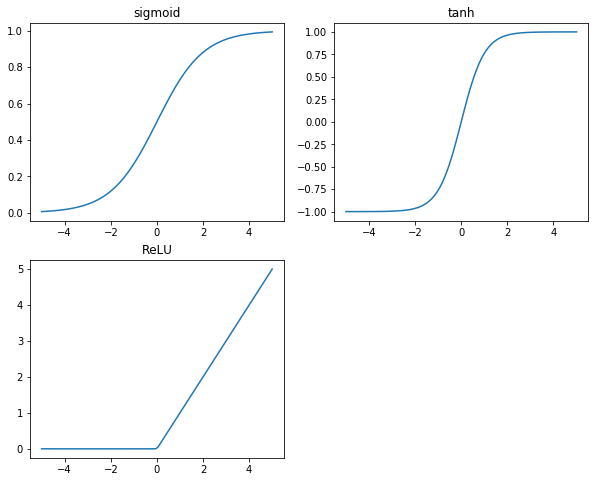

In [2]:
import math
import numpy as np 
import matplotlib.pyplot as plt 

def sigmoid(x): return 1 / (1 + math.exp(-x))
def relu(x):
    if x>0: 
        return x
    else: return 0 

x = np.linspace(-5,5, 100)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(x, [sigmoid(v) for v in x])
plt.title("sigmoid")

plt.subplot(2,2,2)
plt.plot(x, np.tanh(x))
plt.title("tanh")

plt.subplot(2,2,3)
plt.plot(x, [relu(v) for v in x])
plt.title("ReLU")
plt.show()

TRAIN
p= 0 i= 0  loss= 0.307398
p= 1 i= 10000  loss= 1.81332e-07
p= 2 i= 20000  loss= 0.00931463
p= 3 i= 30000  loss= 4.06661e-09
p= 4 i= 40000  loss= 1.12321e-06
p= 5 i= 50000  loss= 2.22448e-06
GRAPH


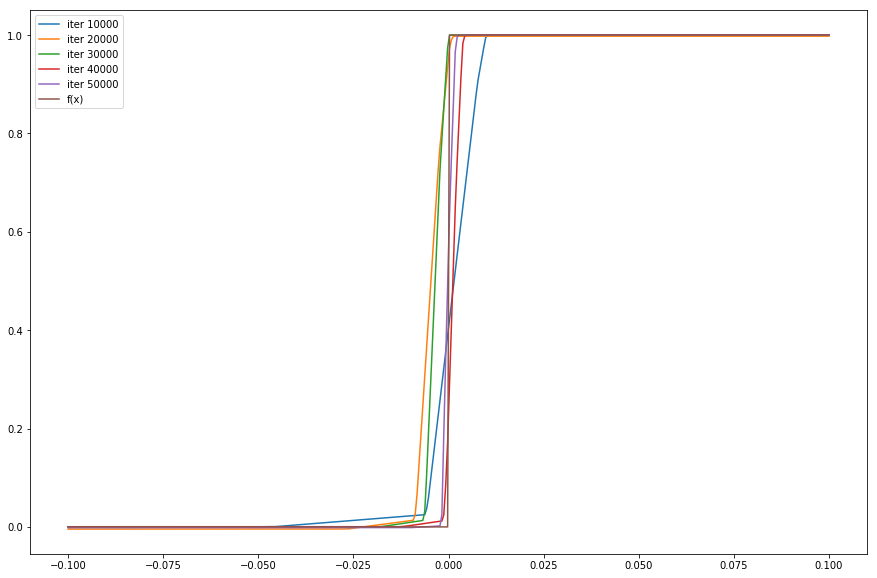

In [14]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf 

def f(x): 
    if x > 0: return 1
    return 0 
#    return math.sin(x*(math.pi/10.0))

mid_layer_size = 5
sdev = 0.25

def learn(x, num_mid):
    # We are constructing a middle layer of 2 perceptron nodes.  Weights and biases 
    # are our w_i and v_i from the above equations. 
    l1_w = tf.Variable(expected_shape=(1, mid_layer_size), 
                       initial_value=tf.truncated_normal((1, mid_layer_size), 
                                                                     mean=0, stddev=sdev))
    l1_b = tf.Variable(expected_shape=(1, mid_layer_size,), 
                       initial_value=tf.truncated_normal((1, mid_layer_size), 
                                                                   mean=0, stddev=sdev))
    mids=[]
    mids.append(tf.nn.relu(tf.add(tf.matmul(x, l1_w), l1_b)))

    for i in range(num_mid):
        mid_w = tf.Variable(expected_shape=(mid_layer_size, mid_layer_size), 
                           initial_value=tf.truncated_normal((mid_layer_size, mid_layer_size), 
                                                                     mean=0, stddev=sdev))
        mid_b = tf.Variable(expected_shape=(1, mid_layer_size,), 
                           initial_value=tf.truncated_normal((1, mid_layer_size), 
                                                                   mean=0, stddev=sdev))
        mids.append(tf.layers.batch_normalization(tf.nn.relu(tf.add(tf.matmul(mids[-1], mid_w), mid_b))))
        
    l3_w = tf.Variable(expected_shape=(mid_layer_size, 1), 
                       initial_value=tf.truncated_normal((mid_layer_size, 1), 
                                                         mean=0, stddev=sdev))
    l3_b = tf.Variable(expected_shape=(1, 1), 
                       initial_value=tf.truncated_normal((1, 1), mean=0, stddev=sdev))

    l3 = tf.add(tf.matmul(mids[-1], l3_w), l3_b)
    output = l3 
    # Our error function is computed as "Mean Squared Difference" between the computed output
    # and the expected value. 
    return output


x = tf.placeholder(shape=(None, 1), dtype=tf.float32, name='x')
y = tf.placeholder(shape=(None, 1), dtype=tf.float32, name='y')

# Learning rate and optimizer similar to our previous examples. 
output = learn(x,3)
loss = tf.reduce_mean(tf.pow(output - y, 2))
optimizer = tf.train.AdamOptimizer()
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(loss)

with tf.Session() as sess: 
    sess.run([tf.local_variables_initializer(), 
              tf.global_variables_initializer()])
    
    print "TRAIN"
    plt.figure(figsize=(15,10))
    batch_size = 100
    train_iterations = 50000
    p = 0 
    for i in xrange(train_iterations+1):
        feed = {x:[], y:[]}
        for b in xrange(batch_size):
            v = random.uniform(-10, 10)
            feed[x].append([v,])
            feed[y].append([f(v)])
        _, l, out = sess.run([train_op, loss, output], feed_dict=feed)
        if i%10000 == 0:
            print "p=", p, "i=",i," loss=", l
            if p > 0:
                tx = np.linspace(-.1,.1,400)
                ys = sess.run(output, feed_dict={x:[[t,] for t in tx],})
                plt.plot(tx, [v[0] for v in ys], label="iter %d" % i)
                # print "feed = ", feed, " output = ", out
            p+=1
            
   
    print "GRAPH"
    tx = np.linspace(-.1,.1,400)
    plt.plot(tx, [f(t) for t in tx], label="f(x)")
    plt.legend()
    plt.show()

## You can play with this code!

Here's a collection of random ideas for how to play around with the code example above and gain some insights:

* Modify the "f()" function to try other linear combinations of x & y.  Can it learn $x-y$?  Can it learn $0.5x + 0.75y - 0.33$? 
* Modify the size of the middle layer.  We use 2 middle layer nodes.  What if you use 200?  How does that impact learning rate?   
* Modify the size of the middle layer, and have it try to learn something "Hard" like $x\cdot y$. Did it work?  Do you have any thoughts about why or why not?